# Descripción del Proyecto.

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Estudiar diferentes métricas: el embudo de ventas, cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Observar los resultados de un test A/A/B basado en las fuentes de toda la aplicación, la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.


## Importación de librerías y datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind

In [2]:
logs = pd.read_csv("/datasets/logs_exp_us.csv", sep='\t')
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Renombrar columnas

In [4]:
logs = logs.rename(columns={'EventName':'event','DeviceIDHash':'user_id','EventTimestamp':'event_ts','ExpId':'group'})

### Revisar y eliminar duplicados

In [5]:
logs[logs.duplicated()]

,event,user_id,event_ts,group
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [6]:
logs = logs.drop_duplicates()

### Convertir columnas a tipos de datos correctos

In [7]:
logs['event_ts'] = pd.to_datetime(logs['event_ts'], unit='s')

### Crear nueva columna con fechas

In [8]:
logs['date'] = logs['event_ts'].values.astype(dtype='datetime64[D]')

## Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [9]:
print(f'Se tienen los datos de {len(logs)} eventos.')

Se tienen los datos de 243713 eventos.


### ¿Cuántos usuarios y usuarias hay en los registros?

In [10]:
print(f'Hay {logs["user_id"].nunique()} usuarios/as.')

Hay 7551 usuarios/as.


### ¿Cuál es el promedio de eventos por usuario?

In [11]:
print(f'Un usuario promedio tiene {round(len(logs) / logs["user_id"].nunique())} eventos durante el experimento.')

Un usuario promedio tiene 32 eventos durante el experimento.


### ¿Qué periodo de tiempo cubren los datos?

#### Encuentra la fecha máxima y mínima. 

In [12]:
print(f'Fecha más antigua del experimento: {logs["date"].min()}')
print(f'Fecha más reciente del experimento: {logs["date"].max()}')

Fecha más antigua del experimento: 2019-07-25 00:00:00
Fecha más reciente del experimento: 2019-08-07 00:00:00


#### Traza un histograma por fecha y hora.

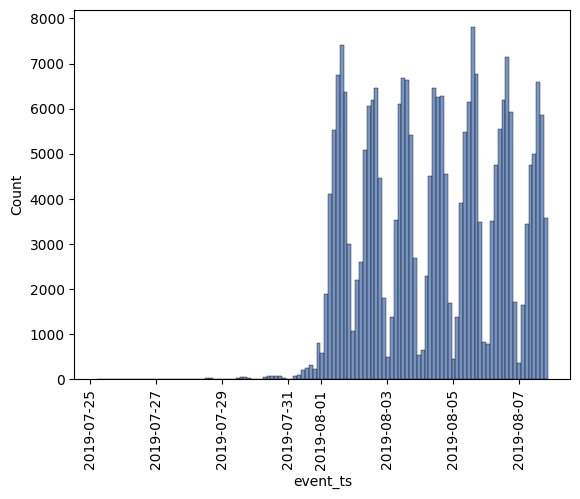

In [13]:
plt.style.use('seaborn-deep')

plt.figure()
sns.histplot(data = logs, x = 'event_ts')
plt.xticks(rotation=90)
plt.show()

#### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?
Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

Basado en el gráfico anterior tomaré los datos de 2019-08-01 en adelante ya que es donde ocurren la mayoría de eventos en los datos que tenemos, pueden faltar registros anteriores por lo que usar datos incompletos sería perjudicial para el análisis.

In [14]:
filter_logs = logs[logs['date'] >= '2019-08-01']
filter_logs.shape

(240887, 5)

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [15]:
print(logs.shape)
print(filter_logs.shape)

(243713, 5)
(240887, 5)


Es una parte muy pequeña del dataset original la que eliminé por lo que no debería afectar negativamente al análisis.

### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [16]:
exp_groups = filter_logs.groupby('group')['user_id'].nunique().reset_index()
exp_groups

,group,user_id
0,246,2484
1,247,2513
2,248,2537


Los tres grupos poseen cantidades muy parecidas de eventos por lo que confío los resultados que se obtendrán son confiables.

## Estudiar el embudo de eventos


### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.


In [17]:
funnel = filter_logs.groupby('event')['user_id'].count().sort_values(ascending = False).reset_index()
funnel = funnel.rename(columns={'user_id':'count'})
funnel


,event,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


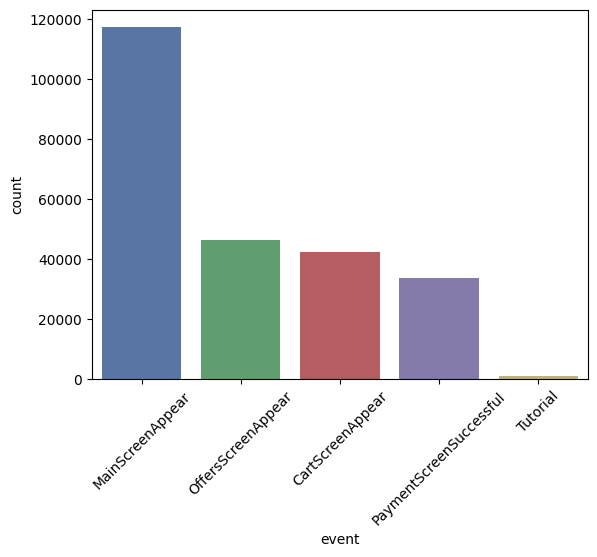

In [18]:
plt.figure()
sns.barplot(data = funnel, x= 'event', y= 'count')
plt.xticks(rotation = 45)
plt.show()

### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. 

In [19]:
users = filter_logs.groupby('event')['user_id'].nunique().sort_values(ascending = False).reset_index()
users = users.rename(columns = {'user_id':'n_of_users'})

In [20]:
users

,event,n_of_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


#### Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [21]:
total_users = filter_logs['user_id'].nunique()
total_users

7534

In [22]:
users['percentage_of_users'] = (users['n_of_users'] / total_users)
users 

,event,n_of_users,percentage_of_users
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

Basado en los nombres de los eventos: 

1. 'MainScreenAppear' ocurre para todos los que entran a la página principal de la tienda.

2. 'OffersScreenAppear' es la página de ofertas del momento, los usuarios la ven mientras realizan las compras.

3. 'CartScreenAppear' cuando los usuarios ven su carrito de compras previo al pago.

4. 'PaymentScreenSuccesful' La compra ha sido exitosa, paso final de cada transacción.

5. 'Tutorial' Es un tutorial opcional de como comprar.

Paso 1 es el más común, los usuarios entran a la página principal al querer hacer una compra.

Paso 2 puede ocurrir luego del paso 1 o podría ser un link directo en a traves de ads.

Pasos 3 y 4 siempre ocurren en secuencia y luego de los pasos anteriores.

Paso 5 es opcional y de ahí que pocos usuarios lo hagan.

### Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [23]:

users['proportion'] = (users['percentage_of_users']*100 / users['percentage_of_users'].shift(1)).round(2)
users

,event,n_of_users,percentage_of_users,proportion
0,MainScreenAppear,7419,0.984736,NaN
1,OffersScreenAppear,4593,0.609636,61.91
2,CartScreenAppear,3734,0.495620,81.30
3,PaymentScreenSuccessful,3539,0.469737,94.78
4,Tutorial,840,0.111495,23.74


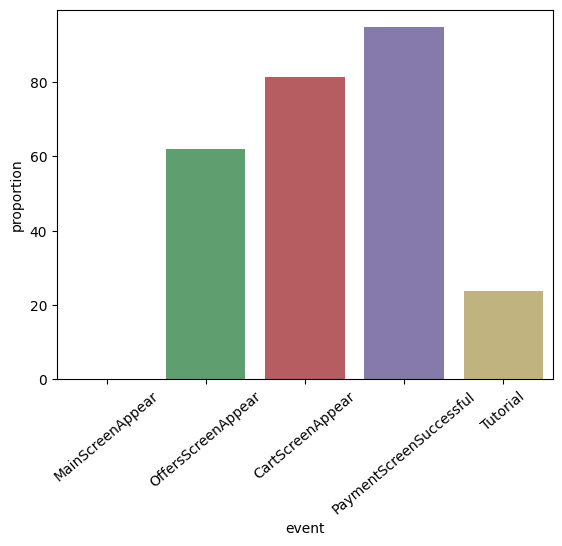

In [24]:
sns.barplot(data = users, x = 'event', y = 'proportion')
plt.xticks(rotation = 40)
plt.show()

### ¿En qué etapa pierdes más usuarios y usuarias?


De la primera a segunda etapa es cuando se pierden más usuarios con 61.91% de los usuarios originales en la secuencia de eventos. Sin embargo solo 11.15% de los usuarios realiza el tutorial por lo que para este evento en particular hay una pérdida de 88.85% en relación al número de usuarios.

### ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [25]:
final_buyers = ((users['n_of_users'].iloc[3] / users['n_of_users'].iloc[0]) * 100).round(2)
print(f'El {final_buyers}% de usuarios que visitan la página realiza todo el proceso de compra. \nConsiderando que casi la mitad de los visitantes realiza una compra es una tasa de retención bastante alta')

El 47.7% de usuarios que visitan la página realiza todo el proceso de compra. 
Considerando que casi la mitad de los visitantes realiza una compra es una tasa de retención bastante alta


## Estudiar los resultados del experimento

### ¿Cuántos usuarios y usuarias hay en cada grupo?


In [26]:
exp_groups = exp_groups.rename(columns = {'group':'group','user_id':'number_of_users'})
exp_groups

,group,number_of_users
0,246,2484
1,247,2513
2,248,2537


Los tres grupos cuentan con aproximadamente el mismo número de usuarios.

### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [27]:
pivot_logs = filter_logs.pivot_table(index = 'event',
                                     columns = 'group',
                                     values = 'user_id',
                                     aggfunc = 'nunique').reset_index()
pivot_logs = pivot_logs.sort_values(by = 246, ascending=False)

In [28]:
pivot_logs

group,event,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [29]:
#Defino un alpha original de 5%
alpha = 0.05

#Luego de los experimentos redefino el valor para reducir el riesgo de errores (5 experimentos, 5% / 5 = 1%)
alpha = 0.01

In [30]:
t_stat, p_value = ttest_ind(pivot_logs[246], pivot_logs[247])
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

if (p_value < alpha):
        print('Rechazamos la hipótesis nula, los grupos son diferentes')
else:
        print('No puede rechazarse la hipótesis nula.')
        

T-statistic: 0.02462483464245995
P-value: 0.9809573661651472
No puede rechazarse la hipótesis nula.


Estos valores sugieren que las dos muestras son prácticamente indistinguibles en términos estadísticos. Funcionan como grupos de control de nuestra prueba.

### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

Para los tres grupos "MainScreenAppear" es el evento más popular.

In [31]:
pivot_logs.head(1)

group,event,246,247,248
1,MainScreenAppear,2450,2476,2493


In [32]:
#Hago la función para obtener las proporciones de los tres grupos
pivot_logs['proportion_246'] = np.nan
pivot_logs['proportion_247'] = np.nan
pivot_logs['proportion_248'] = np.nan

def proportion_col(ctrl_1, ctrl_2, ctrl_3, event):
    group_1 = pivot_logs[pivot_logs['event'] == event][ctrl_1].iloc[0]
    group_2 = pivot_logs[pivot_logs['event'] == event][ctrl_2].iloc[0]
    group_3 = pivot_logs[pivot_logs['event'] == event][ctrl_3].iloc[0]

    users_1 = filter_logs[filter_logs['group'] == ctrl_1]['user_id'].nunique()
    users_2 = filter_logs[filter_logs['group'] == ctrl_2]['user_id'].nunique()
    users_3 = filter_logs[filter_logs['group'] == ctrl_3]['user_id'].nunique()

    prop_1 = group_1 / users_1
    prop_2 = group_2 / users_2
    prop_3 = group_3 / users_3

    pivot_logs.loc[pivot_logs['event'] == event, 'proportion_246'] = prop_1.round(2)
    pivot_logs.loc[pivot_logs['event'] == event, 'proportion_247'] = prop_2.round(2)
    pivot_logs.loc[pivot_logs['event'] == event, 'proportion_248'] = prop_3.round(2)

for x in pivot_logs['event']:
    proportion_col(246, 247, 248, x)

In [33]:
pivot_logs

group,event,246,247,248,proportion_246,proportion_247,proportion_248
1,MainScreenAppear,2450,2476,2493,0.99,0.99,0.98
2,OffersScreenAppear,1542,1520,1531,0.62,0.60,0.60
0,CartScreenAppear,1266,1238,1230,0.51,0.49,0.48
3,PaymentScreenSuccessful,1200,1158,1181,0.48,0.46,0.47
4,Tutorial,278,283,279,0.11,0.11,0.11


In [34]:
t_stat_1, p_value_1 = ttest_ind(pivot_logs['proportion_246'], pivot_logs['proportion_247'])
print(f'T-statistic: {t_stat_1}')
print(f'P-value: {p_value_1}')

if (p_value_1 < alpha):
        print('Rechazamos la hipótesis nula, los grupos son diferentes')
else:
        print('No puede rechazarse la hipótesis nula.')

T-statistic: 0.06008718968345722
P-value: 0.9535601211136968
No puede rechazarse la hipótesis nula.


Nuevamente no hay diferencias estadísticas entre ambos grupos de control por lo que ambos grupos están divididos de forma adecuada.

### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [35]:
# vs 246
t_stat_2, p_value_2 = ttest_ind(pivot_logs['proportion_246'], pivot_logs['proportion_248'])
print(f'T-statistic: {t_stat_2}')
print(f'P-value: {p_value_2}')

if (p_value_2 < alpha):
        print('Rechazamos la hipótesis nula, los grupos son diferentes')
else:
        print('No puede rechazarse la hipótesis nula.')

T-statistic: 0.07052382164493949
P-value: 0.9455078264617658
No puede rechazarse la hipótesis nula.


In [36]:
# vs 247
t_stat_3, p_value_3 = ttest_ind(pivot_logs['proportion_247'], pivot_logs['proportion_248'])
print(f'T-statistic: {t_stat_3}')
print(f'P-value: {p_value_3}')

if (p_value_3 < alpha):
        print('Rechazamos la hipótesis nula, los grupos son diferentes')
else:
        print('No puede rechazarse la hipótesis nula.')

T-statistic: 0.010067680958312612
P-value: 0.9922138232335179
No puede rechazarse la hipótesis nula.


In [37]:
# vs ambos combinados
t_stat_4, p_value_4 = ttest_ind(((pivot_logs['proportion_246'] + pivot_logs['proportion_247']) / 2) , pivot_logs['proportion_248'])

if (p_value_4 < alpha):
        print('Rechazamos la hipótesis nula, los grupos son diferentes')
else:
        print('No puede rechazarse la hipótesis nula.')

No puede rechazarse la hipótesis nula.


No parecen haber diferencias entre los grupos de control y fuentes alteradas.

### ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

Comencé con una significación del 5%, luego lo ajusté de acuerdo a la cantidad de pruebas realizadas, sin embargo las conclusiones originales no cambiaron.

## Conclusiones.

Los usuarios visitan con frecuencia la página, aunque no realizan una compra cada vez, si hay una tasa de retención alta lo que es un buen indicativo.

Casi siempre el acceso al sitio web es directamente a traves de la página principal.

Pocas personas realizan en tutorial así que no es necesario para la mayoría y la experiencia de compra parece ser intuitiva pero está disponible para aquellos usuarios que no sepan como hacerlo. 

Basados en las distintas pruebas de hipótesis realizadas y comparativas con los grupos de control, el cambio de fuente no parece afectar de ningún modo el flujo de la página. Puede aplicarse para dar un aspecto más acorde a la imagen que se quiere pero se recomienda buscar otras alternativas para aumentar el número de clientes.